## Import modules, data and packages

In [3]:
import src.road_network.create_graph as cg
import src.vehicle_models.energy_consumption as ec
import simulation.simulate_routes as sr
import main as m
import json
import math
import pandas as pd
import random
from pprint import pprint
import matplotlib.pyplot as plt

Collect data, and config files

In [4]:
with open("./data_acquisition/test_data.json", "r") as file:
    complete_road_data = json.load(file)
with open("src/vehicle_models/static_data.json", "r") as file:
    static_data = json.load(file)
with open("src/vehicle_models/vehicle_data.json", "r") as file:
    vehicle_data = json.load(file)
with open("src/vehicle_models/battery_data.json", "r") as file:
    battery_data = json.load(file)

road_network_file = './data/random_weight_edge.csv' 
road_df = pd.read_csv(road_network_file)


Define key variables and compile graph

In [5]:
OCV = battery_data["OCV"]
capacity = battery_data["Capacity"]
R_int = battery_data["R_internal"]
motor_eff = vehicle_data["motor_eff"]

graph = cg.create_osmnx_compatible_graph('./data/random_weight_edge.csv')

## Define Variables and Routes

Create random route.

In [6]:
nodes = road_df["u"].to_list()
random_values = random.sample(nodes, 2)
print(random_values)

[4765573948, 6835942106]


Find route using dijkstra's algorithm, plot graph

[4765573948, 982935335, 891026747, 2098022282, 830599351, 430178844, 17585126, 1130492591, 430269402, 430269758, 26165146, 26165138, 1692444887, 26165141, 10751814850, 6835918884, 1692444892, 10751398349, 1692444905, 6835942106]


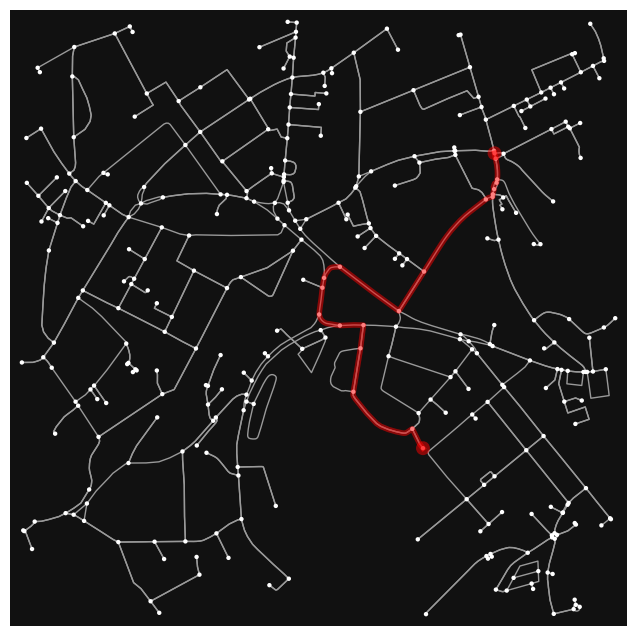

In [7]:
route = cg.dijkstra(graph, random_values[0], random_values[1])
print(route)
fig, ax = cg.plot_graph_with_routes(graph,route)

## Analyse Route and Collect Data

In [15]:
with open("data_acquisition/test_data.json", "r") as file:
    map_data = json.load(file)
cg.find_path_with_nodes(map_data, 17585126, 1130492591)

route_dict = {}

i = 0
for i in range(len(route)-1):
    path = cg.find_path_with_nodes(map_data, route[i], route [i + 1])
    route_dict.update(path)

simulated_route = sr.find_route(map_data,road_df, graph)
sim_dist, sim_consum, sim_climb = sr.return_route_data(route_dict, vehicle_data, static_data, motor_eff)

print(sim_dist, sim_consum, sim_climb)

1333.9126200779192 86.9222718271711 6.02043151855468


Load map data to use for analysis.

In [9]:
with open("data_acquisition/test_data.json", "r") as file:
    map_data = json.load(file)

Match route identified with necessary data

In [10]:
cg.find_path_with_nodes(map_data, 17585126, 1130492591)
route_dict = {}

i = 0
print(len(route))
for i in range(len(route)-1):
    path = cg.find_path_with_nodes(map_data, route[i], route [i + 1])
    route_dict.update(path)

20


In [11]:
consumptions = []
distances = []
climbs = []

for path, pathdata in route_dict.items():
    for section, data in pathdata.items():
        if "section" in section: 
            data["velocity"] = 8.9408
            data["acceleration"] = 0
            tract_power = ec.physical_model(vehicle_data, static_data, data)
            batt_power = ec.battery_power_model(tract_power, motor_eff)

            energy = ec.get_edge_consumption(batt_power, data)

            distances.append(data['distance'])
            consumptions.append(energy)
            climbs.append(data['climb'])

print(f'Energy: {round(sum(consumptions),2)}')
print(f'Climb: {round(sum(climbs),2)}m')
print(f'Distance: {round(sum(distances),2)}m')

Energy: 86.92
Climb: 6.02m
Distance: 1333.91m


route not found
route not found


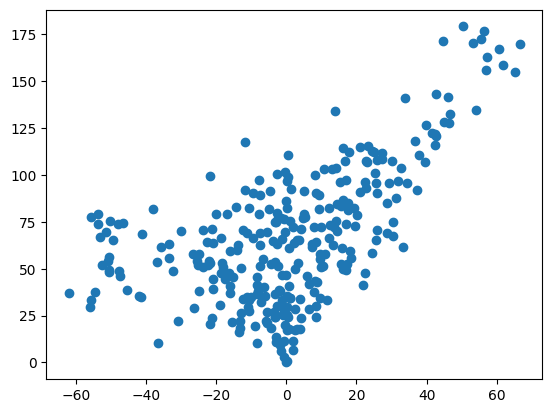

In [12]:
distances = []
consumptions = []
climbs = []

for i in range(1,300):
    try:
        distance, consumption, climb = m.simulate_route()
        distances.append(distance)
        consumptions.append(consumption)
        climbs.append(climb)
    except:
        print("route not found")

plt.scatter(climbs, consumptions)
    